<a href="https://colab.research.google.com/github/manisankar29/MINOR-2/blob/main/MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'brain-tumor-mri-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1608934%2F2645886%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240506%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240506T171847Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1d40075219bdc786b2afaed9ca29c27a632981a830f11309dccf863c08878525787c93091c9abbcccc807bfe5b07223194631f5fb4f80c5371ff26472e29ae0148700b6c08ab342494d85177b2e762d628b401d75c32615de71980efdb0668303bbfad849193536830a98c0d93f03ad020c28c2dc14682c78f21b142874f9e842bb3d2bf3e90e6a14cbd577b720341f0b6740d92176db820a325ae180d0fb0ed3aad423059b5e43ffcb68d2fc9ebade715393cbddcc52ec4def0ceb3c317d9cca95df11efb15ead5ec102328a8cb13d5878757f6413f5ef48d3fbf37e780f30b052f9517087741b8efbdcbf32a323e6a7e7c13d25baad7e6bb94c60138318724'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 155791278 bytes downloaded
Downloaded and uncompressed: brain-tumor-mri-dataset
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1336.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1384.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1232.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0334.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0208.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1114.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0414.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0169.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0612.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1251.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0610.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0841.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1333.jpg
/kaggle/input

In [ ]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

In [ ]:
train_dir = r'../input/brain-tumor-mri-dataset/Training'
test_dir = '../input/brain-tumor-mri-dataset/Testing'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+"//" +label):
        train_paths.append(train_dir + '//'+label+ '//'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

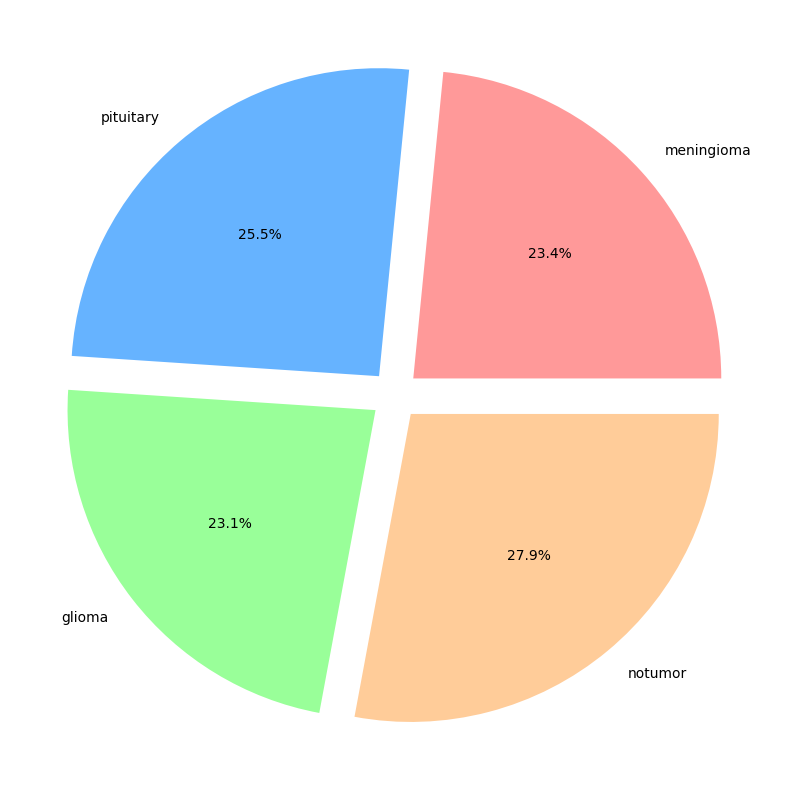

In [ ]:
plt.figure(figsize=(10,10))
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.pie([len(os.listdir(train_dir+"//" +label))
        for label in os.listdir(train_dir)],
         labels=os.listdir(train_dir),
          colors = colors,
           explode = (0.08,0.08,0.08,0.08)
           ,autopct='%1.1f%%')
plt.show()

In [ ]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+ '//' + label):
        test_paths.append(test_dir +'//'+label + '//'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

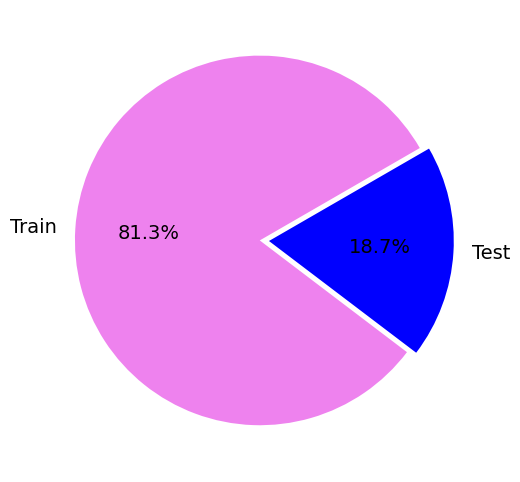

In [ ]:
plt.figure(figsize=(14,6))
colors = ['Violet' , 'Blue']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

In [ ]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Sharpness(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

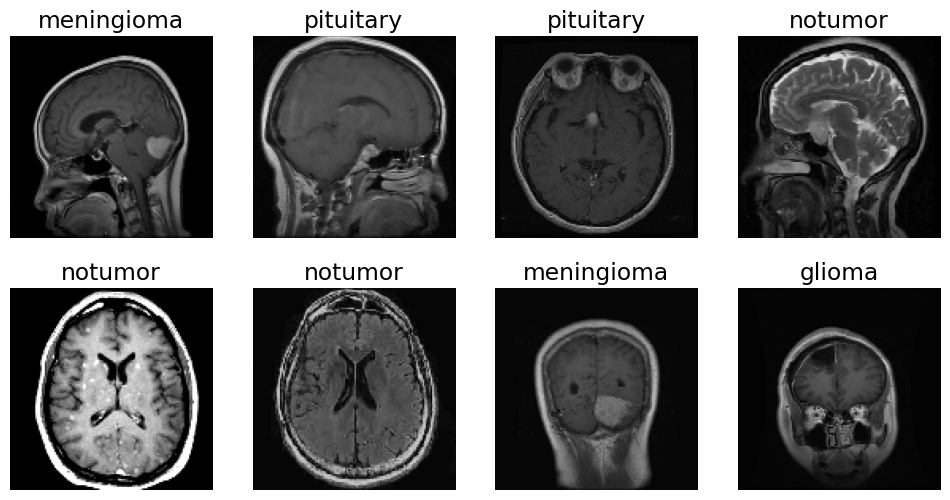

In [ ]:
IMAGE_SIZE = 128


def open_images(paths):

    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)


images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

In [ ]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15763908 (60.13 MB)
Trainable params: 8128

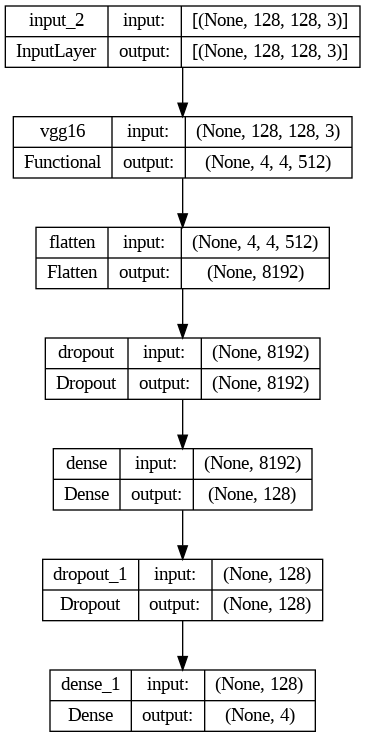

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [ ]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 5s 5s/step


  2%|▎         | 1/40 [00:04<03:12,  4.94s/it]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 2/40 [00:05<01:21,  2.13s/it]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 3/40 [00:05<00:45,  1.24s/it]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 4/40 [00:05<00:29,  1.23it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▎        | 5/40 [00:05<00:20,  1.70it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 6/40 [00:05<00:15,  2.24it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 7/40 [00:05<00:11,  2.83it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 8/40 [00:06<00:09,  3.44it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▎       | 9/40 [00:06<00:07,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 10/40 [00:06<00:07,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 11/40 [00:06<00:07,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 12/40 [00:07<00:07,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▎      | 13/40 [00:07<00:07,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 14/40 [00:07<00:06,  3.85it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 15/40 [00:07<00:06,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 16/40 [00:08<00:06,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▎     | 17/40 [00:08<00:06,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 18/40 [00:08<00:05,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 19/40 [00:08<00:05,  3.79it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 20/40 [00:09<00:05,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▎    | 21/40 [00:09<00:05,  3.76it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 22/40 [00:09<00:04,  4.06it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▊    | 23/40 [00:09<00:03,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 24/40 [00:10<00:03,  4.59it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▎   | 25/40 [00:10<00:03,  4.77it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 26/40 [00:10<00:02,  4.90it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 27/40 [00:10<00:02,  4.96it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 28/40 [00:10<00:02,  5.04it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▎  | 29/40 [00:11<00:02,  5.11it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 30/40 [00:11<00:01,  5.15it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 31/40 [00:11<00:01,  5.10it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 32/40 [00:11<00:01,  5.12it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▎ | 33/40 [00:11<00:01,  5.15it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 34/40 [00:12<00:01,  5.08it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 35/40 [00:12<00:00,  5.06it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 36/40 [00:12<00:00,  5.16it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▎| 37/40 [00:12<00:00,  5.20it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 38/40 [00:12<00:00,  5.24it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 39/40 [00:12<00:00,  5.23it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 40/40 [00:13<00:00,  5.27it/s]

1/1 [==============================] - 3s 3s/step


41it [00:16,  2.50it/s]


In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       300
  meningioma       0.67      0.02      0.04       306
     notumor       0.00      0.00      0.00       405
   pituitary       0.23      1.00      0.37       300

    accuracy                           0.23      1311
   macro avg       0.22      0.25      0.10      1311
weighted avg       0.21      0.23      0.09      1311



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import joblib
joblib.dump(model, '/content/drive/MyDrive/Models/MRI.h5')

['/content/drive/MyDrive/Models/MRI.h5']